# Introducción a los modelos de ML - Regresión

In [1]:
import numpy as np
import pandas as pd
import global_vars as gv
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.tree import plot_tree

In [2]:
# Cargamos el dataset
cars = pd.read_csv(f'{gv.GLOBAL_PATH}/data/cars.csv')

In [3]:
def count_var_categ(sample: pd.Series) -> pd.DataFrame:
    conteo = sample.value_counts().reset_index()
    total = float(np.sum(conteo['count']))
    conteo['Porc %'] = np.round(conteo['count']/total*100,2)
    return conteo

In [4]:
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f'MAE: {mae}, R2: {r2}')
    return mae, r2

In [5]:
# Para modelos lineales (get_dummies y escalado)
def preprocess_linear_models_data(X_test, X_train):
    X_train_cop = X_train.copy()
    X_test_cop = X_test.copy()
    X_train_cop['split'] = 'train'
    X_test_cop['split'] = 'test'
    X = pd.concat([X_train_cop, X_test_cop], axis=0, ignore_index=True)
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    categorical_cols = X.columns.difference(numeric_cols)
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X[numeric_cols]))
    X_scaled.columns = numeric_cols
    X_final = pd.concat([X_scaled, X[categorical_cols]], axis=1)
    X_dum = pd.get_dummies(X_final, drop_first=True, dtype='int')
    X_train_dum = X_dum.loc[X_dum['split_train'] == 1].drop('split_train', axis=1)
    X_test_dum = X_dum.loc[~(X_dum['split_train'] == 1)].drop('split_train', axis=1)
    return X_train_dum.reset_index().drop('index', axis=1), X_test_dum.reset_index().drop('index', axis=1)

In [6]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [7]:
# Generar una heurística para agrupar Make por precio MRSP con segmentación
cars['Make_segment'] = cars['Make']

cars.loc[cars['Make'].isin(['Chevrolet', 'Ford', 'Dodge', 'GMC', 'Chrysler', 'Jeep', 'Ram', 'Buick', 'Cadillac', 'Lincoln']), 'Make_segment'] = 'American'
cars.loc[cars['Make'].isin(['Toyota', 'Nissan', 'Honda', 'Mazda', 'Mitsubishi', 'Subaru', 'Suzuki', 'Hyundai', 'Kia']), 'Make_segment'] = 'Japanese'
cars.loc[cars['Make'].isin(['Mercedes-Benz', 'BMW', 'Audi', 'Volkswagen', 'Volvo', 'Porsche', 'Jaguar', 'Land Rover', 'MINI', 'Maserati', 'Alfa Romeo', 'Genesis', 'Tesla', 'Fiat', 'Bentley', 'Rolls-Royce', 'Lamborghini', 'Lotus', 'McLaren', 'Bugatti']), 'Make_segment'] = 'European'
cars.loc[cars['Make'].isin(['Acura', 'Infiniti', 'Lexus', 'Aston Martin', 'Ferrari']), 'Make_segment'] = 'Luxury'
cars.loc[cars['Make'].isin(['Pontiac', 'Oldsmobile', 'Saab', 'GMC', 'Chrysler', 'Jeep', 'Plymouth', 'FIAT', 'Scion', 'HUMMER',
                            'Maybach', 'Spyker']), 'Make_segment'] = 'Others'

In [8]:
variables_categoricas = ['Make_segment',  'Engine Fuel Type', 'Transmission Type', 'Driven_Wheels', 'Vehicle Size']
variables_numericas = cars.select_dtypes(include=[np.number]).columns

In [9]:
for var in variables_categoricas:
    tmp = count_var_categ(cars[var])
    cars[var] = np.where(cars[var].isin(tmp[f'{var}'].loc[tmp['Porc %'] < 5]), 'Other', cars[var])

In [10]:
variables_modelo = list(variables_numericas) + variables_categoricas

In [11]:
print(variables_modelo)

['Year', 'Engine HP', 'Engine Cylinders', 'Number of Doors', 'highway MPG', 'city mpg', 'Popularity', 'MSRP', 'Make_segment', 'Engine Fuel Type', 'Transmission Type', 'Driven_Wheels', 'Vehicle Size']


In [12]:
cars.isnull().sum()

Make                    0
Model                   0
Year                    0
Engine Fuel Type        3
Engine HP              69
Engine Cylinders       30
Transmission Type       0
Driven_Wheels           0
Number of Doors         6
Market Category      3742
Vehicle Size            0
Vehicle Style           0
highway MPG             0
city mpg                0
Popularity              0
MSRP                    0
Make_segment            0
dtype: int64

In [13]:
cars.dropna(inplace=True)

In [14]:
X = cars[variables_modelo].drop('MSRP', axis=1)
y = cars['MSRP']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
print(f'train: {X_train.shape}, test: {X_test.shape}')

train: (5658, 12), test: (2426, 12)


In [17]:
X_train_dum, X_test_dum = preprocess_linear_models_data(X_test, X_train)

In [18]:
X_train_dum.head()

,Year,Engine HP,Engine Cylinders,Number of Doors,highway MPG,city mpg,Popularity,Driven_Wheels_four wheel drive,Driven_Wheels_front wheel drive,Driven_Wheels_rear wheel drive,...,Engine Fuel Type_regular unleaded,Make_segment_European,Make_segment_Japanese,Make_segment_Luxury,Make_segment_Others,Transmission Type_AUTOMATIC,Transmission Type_MANUAL,Transmission Type_Other,Vehicle Size_Large,Vehicle Size_Midsize
0,0.623872,-0.753439,-0.942793,0.652370,0.951955,1.179732,0.360457,0,1,0,...,0,0,1,0,0,0,1,0,0,0
1,0.623872,-0.301251,-0.942793,0.652370,0.951955,0.341687,1.709334,0,0,0,...,0,1,0,0,0,1,0,0,0,1
2,-1.908739,-1.144756,0.117669,-1.574724,-0.731984,-0.496358,-0.646073,0,0,1,...,0,0,1,0,0,0,1,0,0,0
3,0.149007,0.437903,0.117669,0.652370,-0.343383,-0.356684,-0.926176,0,0,0,...,0,0,0,1,0,1,0,0,0,1
4,-1.592163,-0.736047,0.117669,-1.574724,-0.861518,-0.636032,-0.672244,0,0,1,...,1,0,0,0,1,1,0,0,0,0


In [19]:
print(f'train:{X_train_dum.shape}, test:{X_test_dum.shape}')

train:(5658, 23), test:(2426, 23)


In [20]:
X_train.head()

,Year,Engine HP,Engine Cylinders,Number of Doors,highway MPG,city mpg,Popularity,Make_segment,Engine Fuel Type,Transmission Type,Driven_Wheels,Vehicle Size
6227,2016,188.0,4.0,4.0,34,28,2009,Japanese,premium unleaded (recommended),MANUAL,front wheel drive,Compact
150,2016,240.0,4.0,4.0,34,22,3916,European,premium unleaded (required),AUTOMATIC,all wheel drive,Midsize
1721,2000,143.0,6.0,2.0,21,16,586,Japanese,flex-fuel (unleaded/E85),MANUAL,rear wheel drive,Compact
4307,2013,325.0,6.0,4.0,24,17,190,Luxury,premium unleaded (recommended),AUTOMATIC,all wheel drive,Midsize
9794,2002,190.0,6.0,2.0,20,15,549,Others,regular unleaded,AUTOMATIC,rear wheel drive,Compact


In [21]:
# Label encoding para X_train y X_test
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for var in variables_categoricas:
    X_train[var] = le.fit_transform(X_train[var])
    X_test[var] = le.transform(X_test[var])

In [22]:
X_train.head()

,Year,Engine HP,Engine Cylinders,Number of Doors,highway MPG,city mpg,Popularity,Make_segment,Engine Fuel Type,Transmission Type,Driven_Wheels,Vehicle Size
6227,2016,188.0,4.0,4.0,34,28,2009,2,2,2,2,0
150,2016,240.0,4.0,4.0,34,22,3916,1,3,1,0,2
1721,2000,143.0,6.0,2.0,21,16,586,2,1,2,3,0
4307,2013,325.0,6.0,4.0,24,17,190,3,2,1,0,2
9794,2002,190.0,6.0,2.0,20,15,549,4,4,1,3,0


## Modelo de regresión Lineal (Baseline)

In [23]:
selected_features = stepwise_selection(X_train_dum, y_train.reset_index().drop('index', axis=1))

Add  Engine Cylinders               with p-value 0.0
Add  Engine HP                      with p-value 9.60872e-177
Add  city mpg                       with p-value 4.82892e-36
Add  Make_segment_European          with p-value 7.28035e-32
Add  Vehicle Size_Large             with p-value 3.97438e-21
Add  Vehicle Size_Midsize           with p-value 8.72241e-30
Add  Driven_Wheels_rear wheel drive with p-value 7.09184e-15
Add  Driven_Wheels_four wheel drive with p-value 1.04247e-19
Add  Engine Fuel Type_premium unleaded (required) with p-value 9.79919e-15
Add  Transmission Type_MANUAL       with p-value 1.85844e-10
Add  Transmission Type_AUTOMATIC    with p-value 8.50153e-11
Add  Popularity                     with p-value 6.13642e-09
Add  Transmission Type_Other        with p-value 0.00014872
Add  Make_segment_Others            with p-value 0.000266693
Add  Make_segment_Japanese          with p-value 0.0031192


In [24]:
# Entrenamiento de modelo con variables seleccionadas
lm = LinearRegression()
lm.fit(X_train_dum[selected_features], y_train)

LinearRegression()

In [25]:
# Predicciones en train
y_pred = lm.predict(X_train_dum[selected_features])
_, _ = calculate_metrics(y_train, y_pred)

MAE: 23307.16351118163, R2: 0.5026670990008981


In [26]:
# Predicciones en test
y_pred = lm.predict(X_test_dum[selected_features])
mae, r2 = calculate_metrics(y_test, y_pred)

MAE: 22739.62505251054, R2: 0.5931139985913016


Guardamos la métrica del modelo en un diccionario

In [27]:
metricas_modelos = pd.DataFrame({'Modelo': ['Regresión Lineal (BaseLine)'], 'MAE': [mae], 'R2': [r2]})

In [28]:
metricas_modelos

,Modelo,MAE,R2
0,Regresión Lineal (BaseLine),22739.625053,0.593114


# Modelos basados en árboles

## Árboles de decisión

Los árboles de decisión son un método de aprendizaje supervisado no paramétrico utilizado para clasificación y regresión. El objetivo es crear un modelo que prediga el valor de una variable objetivo mediante el aprendizaje de reglas de decisión simples inferidas de las características de los datos. Un árbol puede ser visto como una aproximación constante por partes. El espacio de entrada se divide en regiones simples de forma recursiva, de manera que las regiones sean homogéneas en la variable de salida. Usa métricas como la ganancia de información, la reducción de la varianza o la reducción del error cuadrático medio para decidir cómo dividir los datos en subconjuntos.

In [29]:
from sklearn.tree import DecisionTreeRegressor

In [30]:
X_train.head()

,Year,Engine HP,Engine Cylinders,Number of Doors,highway MPG,city mpg,Popularity,Make_segment,Engine Fuel Type,Transmission Type,Driven_Wheels,Vehicle Size
6227,2016,188.0,4.0,4.0,34,28,2009,2,2,2,2,0
150,2016,240.0,4.0,4.0,34,22,3916,1,3,1,0,2
1721,2000,143.0,6.0,2.0,21,16,586,2,1,2,3,0
4307,2013,325.0,6.0,4.0,24,17,190,3,2,1,0,2
9794,2002,190.0,6.0,2.0,20,15,549,4,4,1,3,0


In [31]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [32]:
# predicciones en train
y_pred = dt.predict(X_train)
_, _ = calculate_metrics(y_train, y_pred)

MAE: 2069.842637209419, R2: 0.9622723312123005


In [33]:
# predicciones en test
y_pred = dt.predict(X_test)
mae, r2 = calculate_metrics(y_test, y_pred)

MAE: 5240.553082474456, R2: 0.9014042616948014


In [34]:
rd_model = pd.DataFrame({'Modelo': ['Árbol de Decisión'], 'MAE': [mae], 'R2': [r2]})
metricas_modelos = pd.concat([metricas_modelos, rd_model], axis=0)

In [35]:
metricas_modelos

,Modelo,MAE,R2
0,Regresión Lineal (BaseLine),22739.625053,0.593114
0,Árbol de Decisión,5240.553082,0.901404


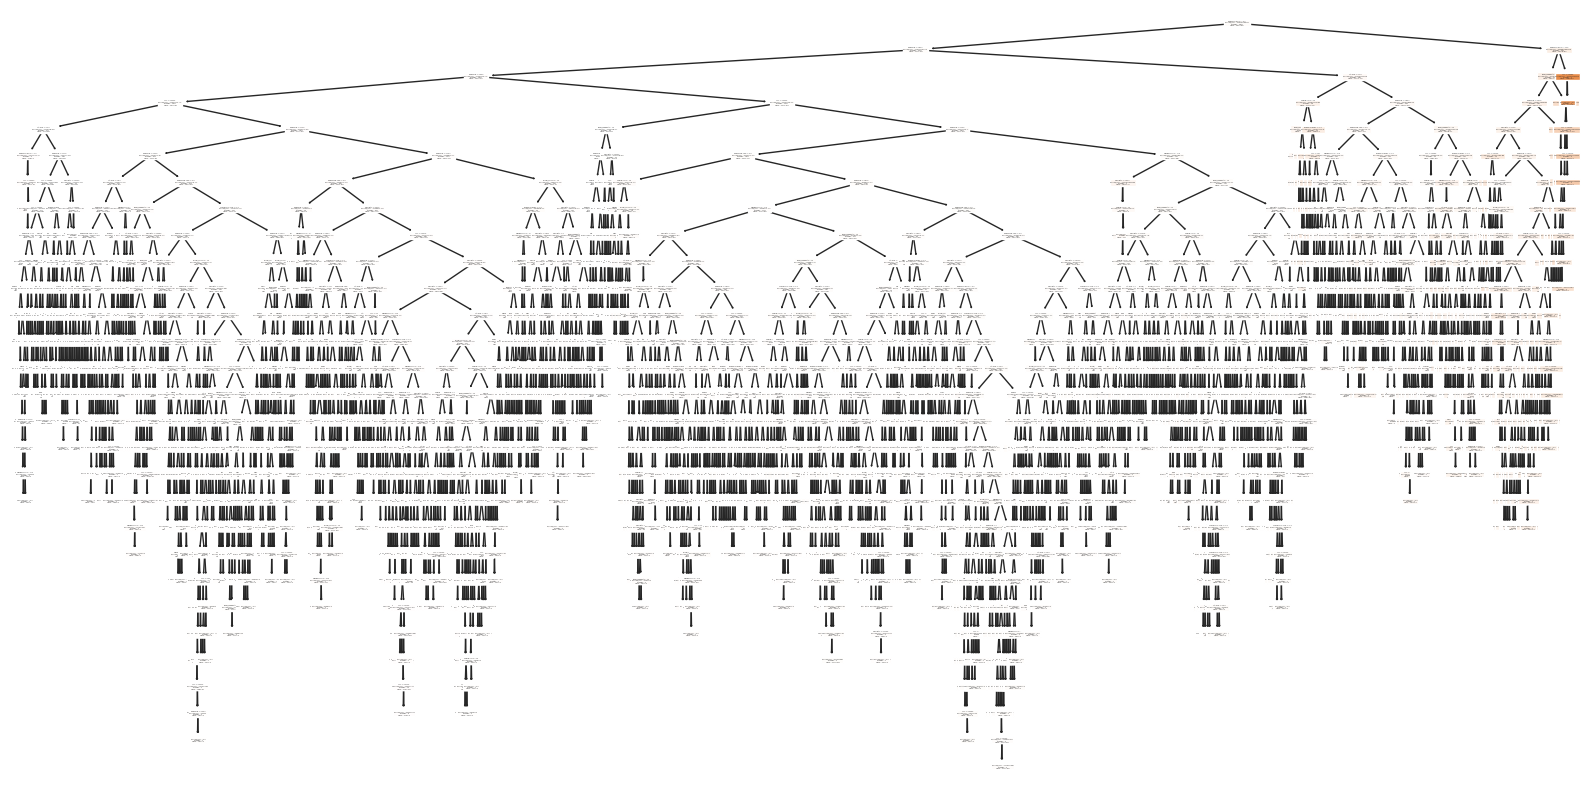

In [36]:
# Visualización del árbol

plt.figure(figsize=(20,10))
plot_tree(dt, filled=True, feature_names=X_train.columns)
plt.show()

In [36]:
# Arbol sencillo e interpretable
dts = DecisionTreeRegressor(random_state=42, max_depth=3, min_samples_split=5, min_samples_leaf=10)
dts.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3, min_samples_leaf=10, min_samples_split=5,
                      random_state=42)

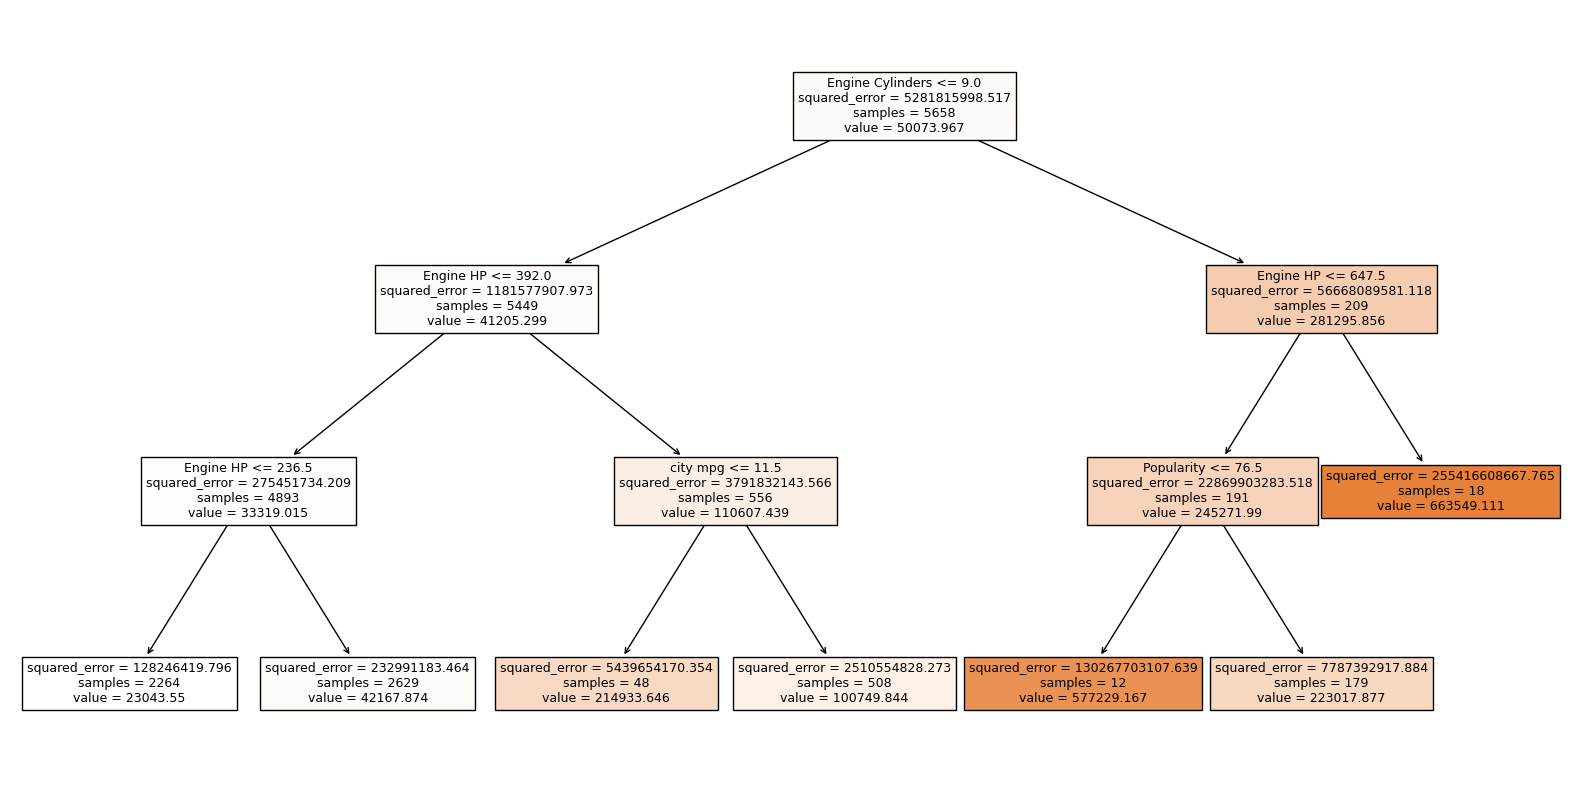

In [37]:
plt.figure(figsize=(20,10))
plot_tree(dts, filled=True, feature_names=X_train.columns)
plt.show()

In [38]:
# predicciones en train
y_pred = dts.predict(X_train)
_, _ = calculate_metrics(y_train, y_pred)

MAE: 15794.715103633242, R2: 0.6655791897180573


### Hiperparámetros


In [39]:
from sklearn.model_selection import GridSearchCV

In [40]:
# Definimos los hiperparámetros
param_grid = {
    'max_depth': [7, 9, 11],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8]
}

In [41]:
# Definimos el modelo
dt = DecisionTreeRegressor(random_state=42)

In [42]:
# Búsqueda de hiperparámetros
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=2, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 45 candidates, totalling 90 fits


GridSearchCV(cv=2, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [7, 9, 11],
                         'min_samples_leaf': [1, 2, 4, 6, 8],
                         'min_samples_split': [2, 5, 10]},
             verbose=2)

In [43]:
# Mejores hiperparámetros
grid_search.best_params_

{'max_depth': 11, 'min_samples_leaf': 2, 'min_samples_split': 2}

In [44]:
# Mejor modelo
dt = grid_search.best_estimator_

In [45]:
# Predicciones en train
y_pred = dt.predict(X_train)
_, _ = calculate_metrics(y_train, y_pred)

MAE: 5203.567791278965, R2: 0.9348866833814068


In [46]:
# Predicciones en test
y_pred = dt.predict(X_test)
mae, r2 = calculate_metrics(y_test, y_pred)

MAE: 6501.310403394034, R2: 0.9068146417965847


In [47]:
rd_model = pd.DataFrame({'Modelo': ['Árbol de Decisión (GridSearch)'], 'MAE': [mae], 'R2': [r2]})

In [48]:
metricas_modelos = pd.concat([metricas_modelos, rd_model], axis=0)

In [49]:
metricas_modelos

,Modelo,MAE,R2
0,Regresión Lineal (BaseLine),22739.625053,0.593114
0,Árbol de Decisión,5240.553082,0.901404
0,Árbol de Decisión (GridSearch),6501.310403,0.906815


In [50]:
# Importancia de las variables
importances = dt.feature_importances_
indices = np.argsort(importances)[::-1]

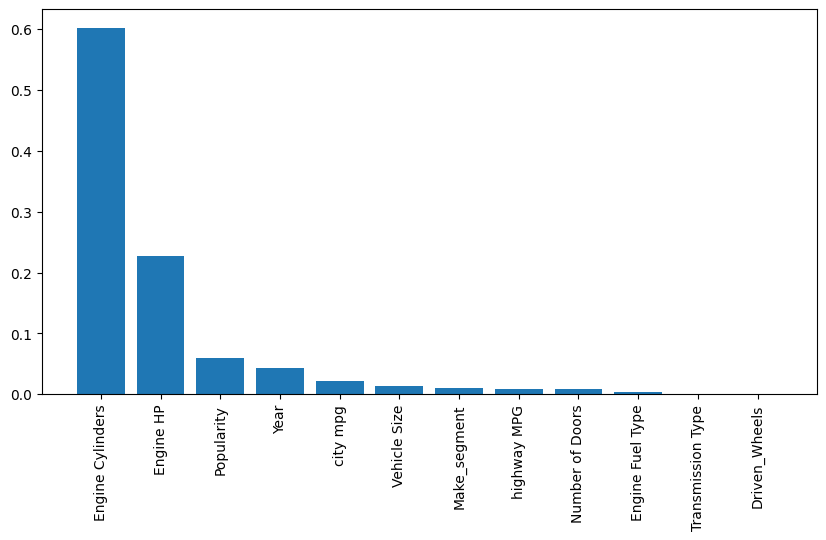

In [51]:
# Visualización de la importancia de las variables
plt.figure(figsize=(10,5))
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), [X_train.columns[i] for i in indices], rotation=90)
plt.show()

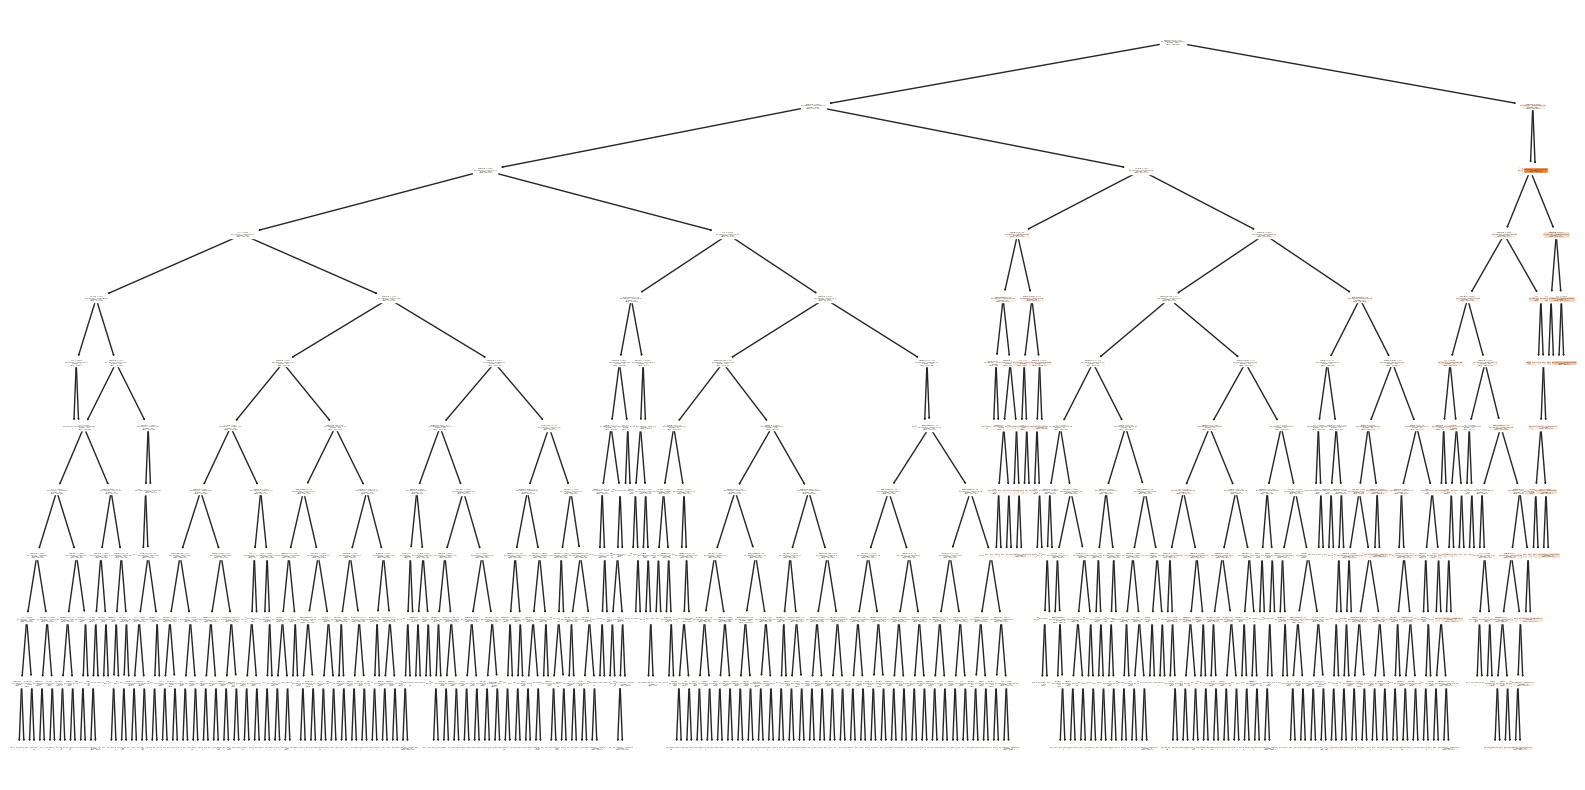

In [50]:
# visualización del mejor árbol
plt.figure(figsize=(20,10))
plot_tree(dt, filled=True, feature_names=X_train.columns)
plt.show()

## Random Forest

El bosque aleatorio es un algoritmo de aprendizaje supervisado que se utiliza para problemas de regresión y clasificación. Es una técnica de conjunto que crea múltiples árboles de decisión y los combina para hacer una predicción. La idea detrás del bosque aleatorio es que la sabiduría de la multitud supera la de los individuos. En general, los bosques aleatorios logran una precisión mucho mayor que los árboles de decisión con una mayor cantidad de hiperparámetros para ajustar. La desventaja es que un bosque aleatorio es menos interpretable y más lento de entrenar y predecir que un solo árbol de decisión.

In [52]:
from sklearn.ensemble import RandomForestRegressor

In [53]:
rf = RandomForestRegressor(random_state=42)

In [54]:
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [55]:
# Predicciones en train
y_pred = rf.predict(X_train)
_, _ = calculate_metrics(y_train, y_pred)

MAE: 3059.8480684060646, R2: 0.9476890900427495


In [56]:
# Predicciones en test
y_pred = rf.predict(X_test)
mae, r2 = calculate_metrics(y_test, y_pred)

MAE: 4695.4805504789465, R2: 0.9522816966053739


In [57]:
rf_model = pd.DataFrame({'Modelo': ['Random Forest'], 'MAE': [mae], 'R2': [r2]})
metricas_modelos = pd.concat([metricas_modelos, rf_model], axis=0)
metricas_modelos

,Modelo,MAE,R2
0,Regresión Lineal (BaseLine),22739.625053,0.593114
0,Árbol de Decisión,5240.553082,0.901404
0,Árbol de Decisión (GridSearch),6501.310403,0.906815
0,Random Forest,4695.480550,0.952282


In [58]:
# GridSearch
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 12, 14],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 6]
}

In [59]:
# Definimos el modelo
rf = RandomForestRegressor(random_state=42)

In [60]:
# Búsqueda de hiperparámetros
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=2, n_jobs=-1, verbose=2)

In [61]:
# Entrenamiento
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 81 candidates, totalling 162 fits


GridSearchCV(cv=2, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 12, 14],
                         'min_samples_leaf': [1, 3, 6],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [62]:
# Mejores hiperparámetros
grid_search.best_params_

{'max_depth': 14,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 100}

In [63]:
# Predicciones en train
y_pred = grid_search.predict(X_train)
_, _ = calculate_metrics(y_train, y_pred)

MAE: 3810.8539312968096, R2: 0.9379392893071762


In [64]:
# Predicciones en test
y_pred = grid_search.predict(X_test)
mae, r2 = calculate_metrics(y_test, y_pred)

MAE: 4753.081437743976, R2: 0.9596292411098184


In [65]:
rf_model = pd.DataFrame({'Modelo': ['Random Forest (GridSearch)'], 'MAE': [mae], 'R2': [r2]})

In [66]:
metricas_modelos = pd.concat([metricas_modelos, rf_model], axis=0)

In [67]:
metricas_modelos

,Modelo,MAE,R2
0,Regresión Lineal (BaseLine),22739.625053,0.593114
0,Árbol de Decisión,5240.553082,0.901404
0,Árbol de Decisión (GridSearch),6501.310403,0.906815
0,Random Forest,4695.480550,0.952282
0,Random Forest (GridSearch),4753.081438,0.959629


In [68]:
# Importancia de las variables
importances = grid_search.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]

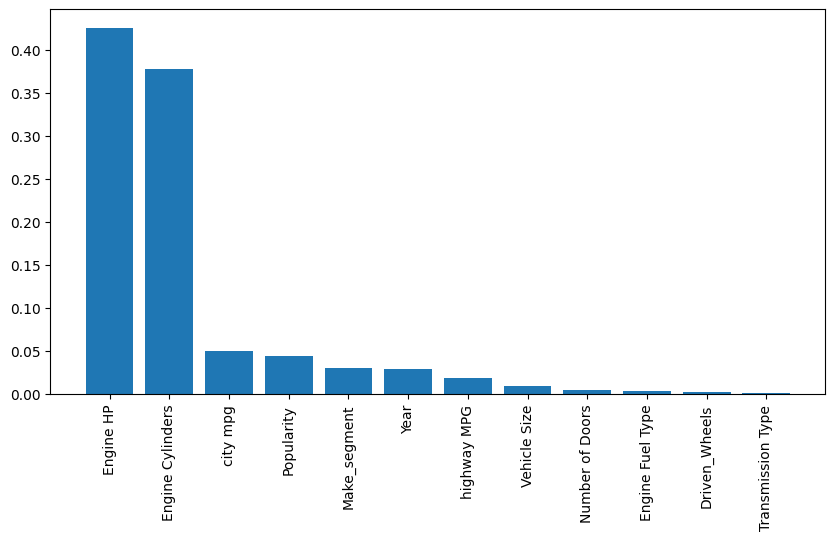

In [69]:
# Visualización de la importancia de las variables
plt.figure(figsize=(10,5))
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), [X_train.columns[i] for i in indices], rotation=90)
plt.show()

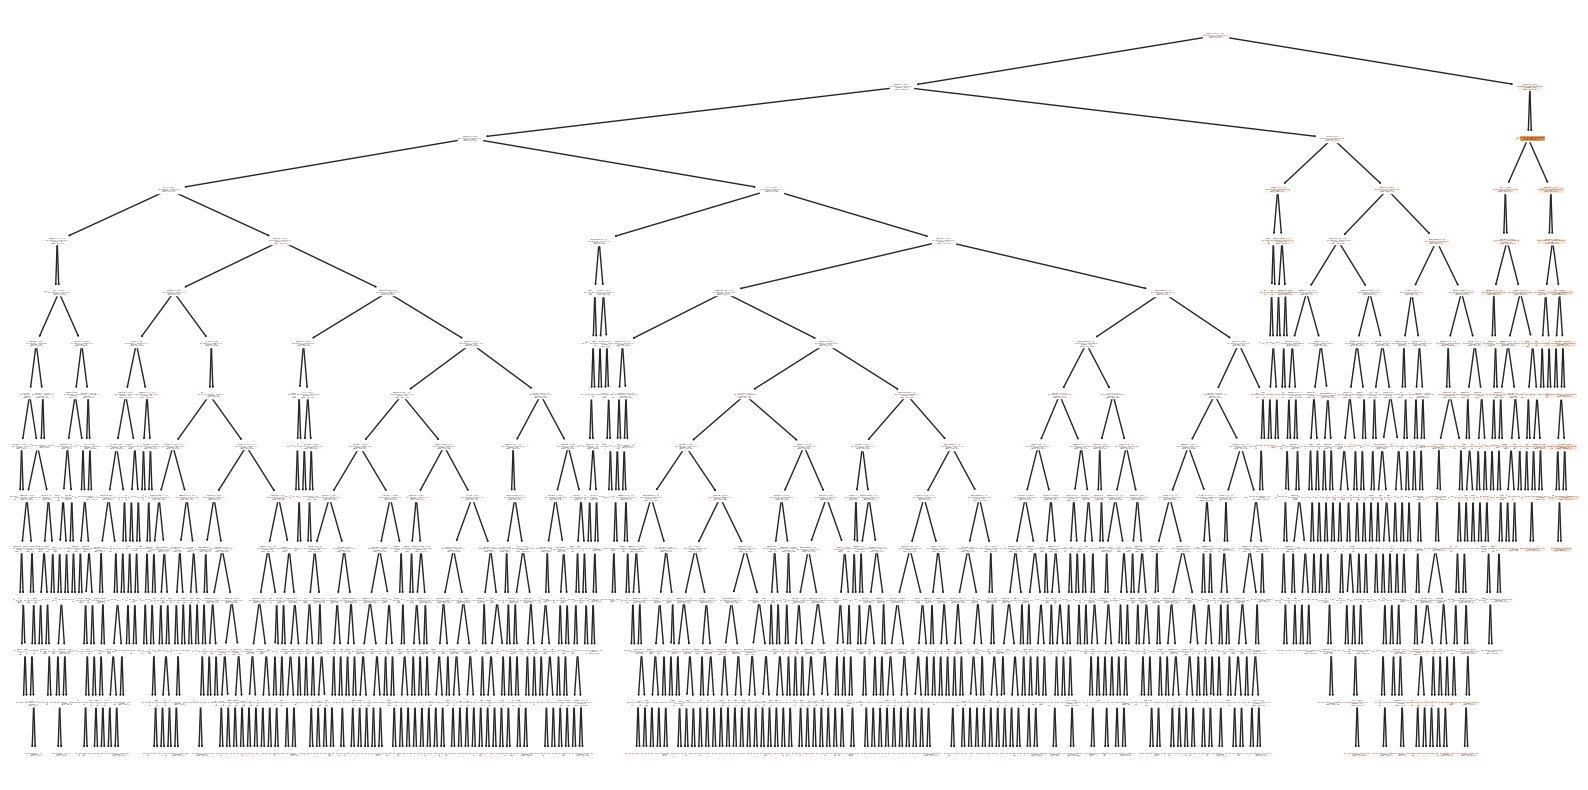

In [71]:
# Visualización de un árbol del bosque
plt.figure(figsize=(20,10))
plot_tree(grid_search.best_estimator_.estimators_[0], filled=True, feature_names=X_train.columns)
plt.show()

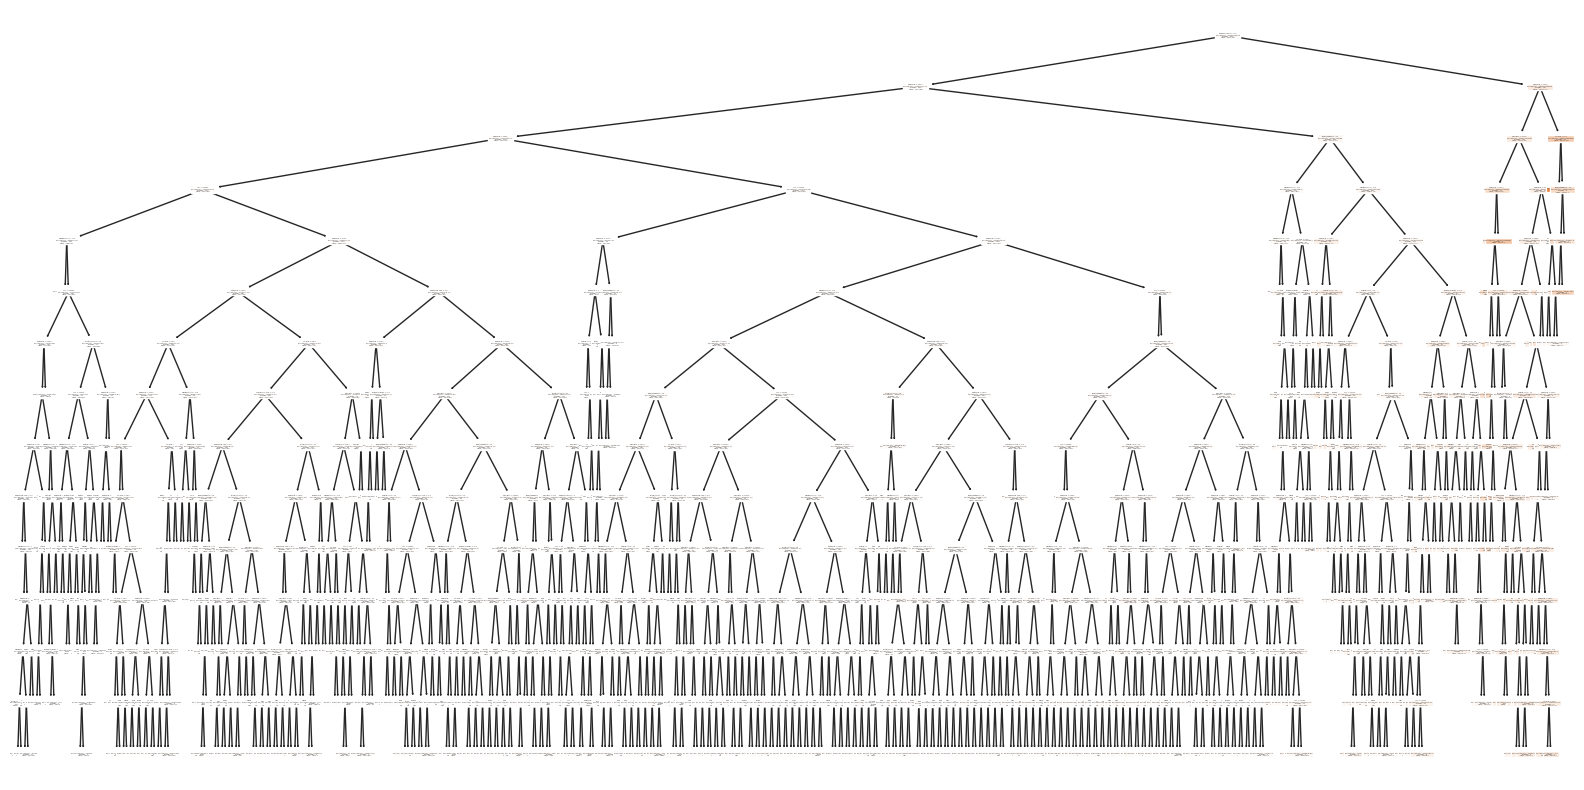

In [72]:
# Visualización de un árbol del bosque
plt.figure(figsize=(20,10))
plot_tree(grid_search.best_estimator_.estimators_[99], filled=True, feature_names=X_train.columns)
plt.show()

## Gradient Boosting (XGBoost)

El XGBoost es una implementación de la técnica de refuerzo de gradiente que se utiliza para problemas de regresión y clasificación. XGBoost es una de las bibliotecas de aprendizaje automático más populares y ampliamente utilizadas entre los practicantes de aprendizaje automático. XGBoost se basa en la técnica de refuerzo de gradiente, que produce un modelo de ensamblaje de árboles de decisión. XGBoost ajusta secuencialmente los árboles de decisión para corregir los errores de los modelos anteriores. La principal diferencia entre XGBoost y otros algoritmos de refuerzo de gradiente es su capacidad para manejar datos dispersos.

In [70]:
xgb_mod = xgb.XGBRegressor(random_state=42)

In [71]:
# Entrenamiento
xgb_mod.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [72]:
# Predicciones en train
y_pred = xgb_mod.predict(X_train)
_, _ = calculate_metrics(y_train, y_pred)

MAE: 3101.2256321345762, R2: 0.9604556239916422


In [73]:
# Predicciones en test
y_pred = xgb_mod.predict(X_test)
mae, r2 = calculate_metrics(y_test, y_pred)

MAE: 4757.664698236753, R2: 0.9244702248117339


In [74]:
# Guardamos las métricas
xgb_model = pd.DataFrame({'Modelo': ['XGBoost'], 'MAE': [mae], 'R2': [r2]})
metricas_modelos = pd.concat([metricas_modelos, xgb_model], axis=0)

In [75]:
metricas_modelos

,Modelo,MAE,R2
0,Regresión Lineal (BaseLine),22739.625053,0.593114
0,Árbol de Decisión,5240.553082,0.901404
0,Árbol de Decisión (GridSearch),6501.310403,0.906815
0,Random Forest,4695.480550,0.952282
0,Random Forest (GridSearch),4753.081438,0.959629
0,XGBoost,4757.664698,0.924470


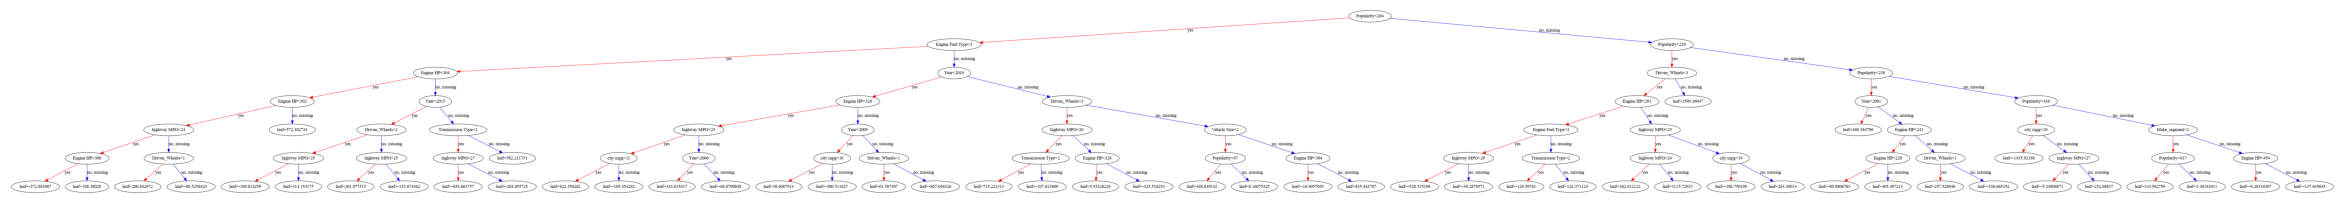

In [105]:
# Grafica un arbol
xgb.plot_tree(xgb_mod, num_trees=99)
fig = plt.gcf()
fig.set_size_inches(30, 15)

Extra: Probar una implementación en LightGBM o CatBoost

## LightGBM

In [76]:
import lightgbm as lgb

In [77]:
lgb_mod = lgb.LGBMRegressor(random_state=42)

In [78]:
# Entrenamiento
lgb_mod.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 429
[LightGBM] [Info] Number of data points in the train set: 5658, number of used features: 12
[LightGBM] [Info] Start training from score 50073.967480


LGBMRegressor(random_state=42)

In [79]:
# Predicciones en train
y_pred = lgb_mod.predict(X_train)
_, _ = calculate_metrics(y_train, y_pred)

MAE: 5394.942725364342, R2: 0.861564656915828


In [80]:
# Predicciones en test
y_pred = lgb_mod.predict(X_test)
mae, r2 = calculate_metrics(y_test, y_pred)

MAE: 5913.447681823273, R2: 0.918061554482718


In [81]:
# Guardamos las métricas
lgb_model = pd.DataFrame({'Modelo': ['LightGBM'], 'MAE': [mae], 'R2': [r2]})
metricas_modelos = pd.concat([metricas_modelos, lgb_model], axis=0)

In [82]:
metricas_modelos

,Modelo,MAE,R2
0,Regresión Lineal (BaseLine),22739.625053,0.593114
0,Árbol de Decisión,5240.553082,0.901404
0,Árbol de Decisión (GridSearch),6501.310403,0.906815
0,Random Forest,4695.480550,0.952282
0,Random Forest (GridSearch),4753.081438,0.959629
0,XGBoost,4757.664698,0.924470
0,LightGBM,5913.447682,0.918062


In [83]:
# Importancia de las variables
importances = lgb_mod.feature_importances_
indices = np.argsort(importances)[::-1]

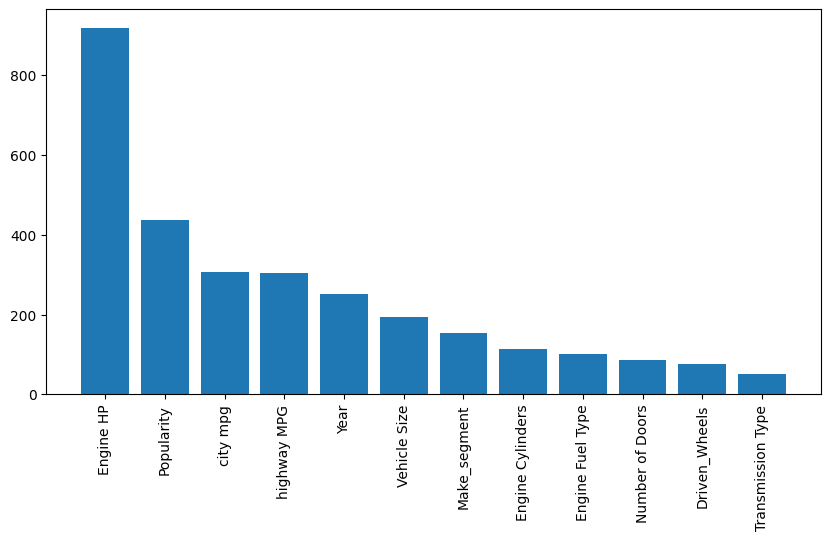

In [84]:
# Visualización de la importancia de las variables
plt.figure(figsize=(10,5))
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), [X_train.columns[i] for i in indices], rotation=90)
plt.show()

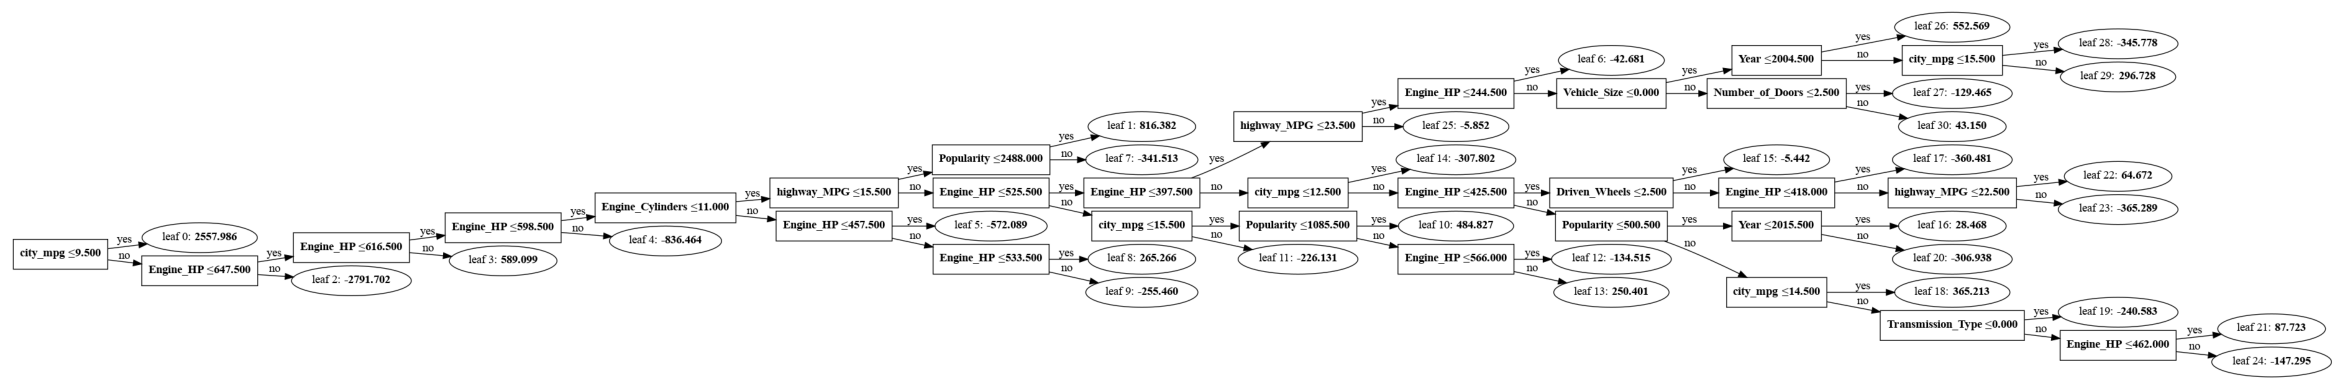

In [85]:
# Visualización de un árbol
lgb.plot_tree(lgb_mod, tree_index=99)
fig = plt.gcf()
fig.set_size_inches(30, 15)

# Otros modelos

## K-Nearest Neighbors

El algoritmo de los k vecinos más cercanos (KNN) es un algoritmo de aprendizaje supervisado que se utiliza para problemas de regresión y clasificación. El algoritmo KNN asume que cosas similares existen en proximidad. En otras palabras, cosas similares están cerca una de la otra. El algoritmo KNN calcula la distancia entre un punto de consulta y todos los puntos de datos. Luego selecciona los k puntos de datos más cercanos, donde k puede ser cualquier número entero. Finalmente, asigna el punto de consulta al grupo al que pertenecen la mayoría de los k puntos de datos más cercanos.

In [86]:
from sklearn.neighbors import KNeighborsRegressor

In [87]:
knn = KNeighborsRegressor()

In [88]:
# Entrenamiento
knn.fit(X_train_dum, y_train)

KNeighborsRegressor()

In [89]:
# Predicciones en train
y_pred = knn.predict(X_train_dum)
_, _ = calculate_metrics(y_train, y_pred)

MAE: 5306.706185931424, R2: 0.8605222942253268


In [90]:
# Predicciones en test
y_pred = knn.predict(X_test_dum)
mae, r2 = calculate_metrics(y_test, y_pred)

MAE: 6330.300164880461, R2: 0.9039847184470879


In [91]:
knn_model = pd.DataFrame({'Modelo': ['K-Nearest Neighbors'], 'MAE': [mae], 'R2': [r2]})
metricas_modelos = pd.concat([metricas_modelos, knn_model], axis=0)
metricas_modelos

,Modelo,MAE,R2
0,Regresión Lineal (BaseLine),22739.625053,0.593114
0,Árbol de Decisión,5240.553082,0.901404
0,Árbol de Decisión (GridSearch),6501.310403,0.906815
0,Random Forest,4695.480550,0.952282
0,Random Forest (GridSearch),4753.081438,0.959629
0,XGBoost,4757.664698,0.924470
0,LightGBM,5913.447682,0.918062
0,K-Nearest Neighbors,6330.300165,0.903985


In [107]:
# GridSearch
param_grid = {
    'n_neighbors': [2, 3, 4, 5, 6, 7, 8], # En clasificación números impares.
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

In [108]:
# Definimos el modelo
knn = KNeighborsRegressor()

In [109]:
# Búsqueda de hiperparámetros
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=2, n_jobs=-1, verbose=2)

In [110]:
# Entrenamiento
grid_search.fit(X_train_dum, y_train)

Fitting 2 folds for each of 28 candidates, totalling 56 fits


GridSearchCV(cv=2, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [2, 3, 4, 5, 6, 7, 8],
                         'weights': ['uniform', 'distance']},
             verbose=2)

In [111]:
# Mejores hiperparámetros
grid_search.best_params_

{'metric': 'manhattan', 'n_neighbors': 2, 'weights': 'distance'}

In [112]:
# Mejor modelo
knn = grid_search.best_estimator_

In [113]:
# Predicciones en train
y_pred = knn.predict(X_train_dum)
_, _ = calculate_metrics(y_train, y_pred)

MAE: 2211.7899434429128, R2: 0.9596025909310766


In [114]:
# Predicciones en test
y_pred = knn.predict(X_test_dum)
mae, r2 = calculate_metrics(y_test, y_pred)

MAE: 5247.478856030041, R2: 0.913766556904257


In [115]:
knn_model = pd.DataFrame({'Modelo': ['K-Nearest Neighbors (GridSearch)'], 'MAE': [mae], 'R2': [r2]})

In [116]:
metricas_modelos = pd.concat([metricas_modelos, knn_model], axis=0)
metricas_modelos

,Modelo,MAE,R2
0,Regresión Lineal (BaseLine),22739.625053,0.593114
0,Árbol de Decisión,5240.553082,0.901404
0,Árbol de Decisión (GridSearch),6501.310403,0.906815
0,Random Forest,4695.480550,0.952282
0,Random Forest (GridSearch),4753.081438,0.959629
0,XGBoost,4757.664698,0.924470
0,LightGBM,5913.447682,0.918062
0,K-Nearest Neighbors,6330.300165,0.903985
0,K-Nearest Neighbors (GridSearch),5247.478856,0.913767


## Regresión Ridge y Lasso

La regresión de Ridge y Lasso son dos métodos de regularización que se utilizan para problemas de regresión. La regresión de Ridge es un método de regularización que agrega una penalización L2 a la función de costo. La regresión de Lasso es un método de regularización que agrega una penalización L1 a la función de costo. La principal diferencia entre estos dos métodos es el término de regularización. La regresión de Ridge minimiza la suma de los cuadrados de los coeficientes (L2), mientras que la regresión de Lasso minimiza la suma de los valores absolutos de los coeficientes (L1). La regresión de Lasso es útil para la selección de características, ya que establece los coeficientes de las características menos importantes en cero. La regresión de Ridge es útil para reducir la multicolinealidad en los datos. Estos métodos son útiles cuando hay muchas características en los datos y se desea evitar el sobreajuste. Su interpretación es más sencilla que la de los árboles de decisión. A diferencia de la regresión lineal, estos métodos no tienen una solución cerrada y deben ser ajustados con un parámetro de regularización.

In [119]:
from sklearn.linear_model import Ridge, Lasso

In [120]:
# Ridge
ridge = Ridge(random_state=42)

In [121]:
# Entrenamiento
ridge.fit(X_train_dum[selected_features], y_train)

Ridge(random_state=42)

In [122]:
# Predicciones en train
y_pred = ridge.predict(X_train_dum[selected_features])
_, _ = calculate_metrics(y_train, y_pred)

MAE: 23301.918226305643, R2: 0.5026495975233796


In [124]:
# Predicciones en test
y_pred = ridge.predict(X_test_dum[selected_features])
mae, r2 = calculate_metrics(y_test, y_pred)

MAE: 22744.929342987274, R2: 0.592968863770247


In [125]:
ridge_model = pd.DataFrame({'Modelo': ['Ridge'], 'MAE': [mae], 'R2': [r2]})
metricas_modelos = pd.concat([metricas_modelos, ridge_model], axis=0)

In [126]:
metricas_modelos

,Modelo,MAE,R2
0,Regresión Lineal (BaseLine),22739.625053,0.593114
0,Árbol de Decisión,5240.553082,0.901404
0,Árbol de Decisión (GridSearch),6501.310403,0.906815
0,Random Forest,4695.480550,0.952282
0,Random Forest (GridSearch),4753.081438,0.959629
0,XGBoost,4757.664698,0.924470
0,LightGBM,5913.447682,0.918062
0,K-Nearest Neighbors,6330.300165,0.903985
0,K-Nearest Neighbors (GridSearch),5247.478856,0.913767
0,Ridge,22744.929343,0.592969


In [127]:
# GridSearch
param_grid = {
    'alpha': [0.01, 0.05, 0.1, 1, 5, 10, 30, 50, 80, 100, 200, 500]
}  

In [128]:
# Definimos el modelo
ridge = Ridge(random_state=42)

In [129]:
# Búsqueda de hiperparámetros
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=2, n_jobs=-1, verbose=2)

In [130]:
# Entrenamiento
grid_search.fit(X_train_dum[selected_features], y_train)

Fitting 2 folds for each of 12 candidates, totalling 24 fits


GridSearchCV(cv=2, estimator=Ridge(random_state=42), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.05, 0.1, 1, 5, 10, 30, 50, 80, 100,
                                   200, 500]},
             verbose=2)

In [131]:
# Mejores hiperparámetros
grid_search.best_params_

{'alpha': 0.1}

In [132]:
# Mejor modelo
ridge = grid_search.best_estimator_

In [133]:
# Predicciones en train
y_pred = ridge.predict(X_train_dum[selected_features])
_, _ = calculate_metrics(y_train, y_pred)

MAE: 23306.637711453295, R2: 0.5026668823034692


In [134]:
# Predicciones en test
y_pred = ridge.predict(X_test_dum[selected_features])
mae, r2 = calculate_metrics(y_test, y_pred)

MAE: 22740.311146403354, R2: 0.5930996564051203


In [135]:
ridge_model = pd.DataFrame({'Modelo': ['Ridge (GridSearch)'], 'MAE': [mae], 'R2': [r2]})
metricas_modelos = pd.concat([metricas_modelos, ridge_model], axis=0)
metricas_modelos

,Modelo,MAE,R2
0,Regresión Lineal (BaseLine),22739.625053,0.593114
0,Árbol de Decisión,5240.553082,0.901404
0,Árbol de Decisión (GridSearch),6501.310403,0.906815
0,Random Forest,4695.480550,0.952282
0,Random Forest (GridSearch),4753.081438,0.959629
0,XGBoost,4757.664698,0.924470
0,LightGBM,5913.447682,0.918062
0,K-Nearest Neighbors,6330.300165,0.903985
0,K-Nearest Neighbors (GridSearch),5247.478856,0.913767
0,Ridge,22744.929343,0.592969


In [136]:
# Lasso
lasso = Lasso(random_state=42)

In [137]:
# Entrenamiento
lasso.fit(X_train_dum[selected_features], y_train)

Lasso(random_state=42)

In [138]:
# Predicciones en train
y_pred = lasso.predict(X_train_dum[selected_features])
_, _ = calculate_metrics(y_train, y_pred)

MAE: 23304.826347668983, R2: 0.5026669261154705


In [139]:
# Predicciones en test
y_pred = lasso.predict(X_test_dum[selected_features])
mae, r2 = calculate_metrics(y_test, y_pred)

MAE: 22738.08302325497, R2: 0.5931131446600991


In [140]:
lasso_model = pd.DataFrame({'Modelo': ['Lasso'], 'MAE': [mae], 'R2': [r2]})
metricas_modelos = pd.concat([metricas_modelos, lasso_model], axis=0)
metricas_modelos

,Modelo,MAE,R2
0,Regresión Lineal (BaseLine),22739.625053,0.593114
0,Árbol de Decisión,5240.553082,0.901404
0,Árbol de Decisión (GridSearch),6501.310403,0.906815
0,Random Forest,4695.480550,0.952282
0,Random Forest (GridSearch),4753.081438,0.959629
0,XGBoost,4757.664698,0.924470
0,LightGBM,5913.447682,0.918062
0,K-Nearest Neighbors,6330.300165,0.903985
0,K-Nearest Neighbors (GridSearch),5247.478856,0.913767
0,Ridge,22744.929343,0.592969


In [141]:
# GridSearch
param_grid = {
    'alpha': [0.01, 0.05, 0.1, 1, 5, 10, 30, 50, 80, 100, 200, 500]
}

In [142]:
# Definimos el modelo
lasso = Lasso(random_state=42)

In [143]:
# Búsqueda de hiperparámetros
grid_search = GridSearchCV(estimator=lasso, param_grid=param_grid, cv=2, n_jobs=-1, verbose=2)

In [144]:
# Entrenamiento
grid_search.fit(X_train_dum[selected_features], y_train)

Fitting 2 folds for each of 12 candidates, totalling 24 fits


GridSearchCV(cv=2, estimator=Lasso(random_state=42), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.05, 0.1, 1, 5, 10, 30, 50, 80, 100,
                                   200, 500]},
             verbose=2)

In [145]:
# Mejores hiperparámetros
grid_search.best_params_

{'alpha': 5}

In [146]:
# Mejor modelo
lasso = grid_search.best_estimator_

In [147]:
# Predicciones en train
y_pred = lasso.predict(X_train_dum[selected_features])
_, _ = calculate_metrics(y_train, y_pred)

MAE: 23295.573733286692, R2: 0.5026627759864548


In [148]:
# Predicciones en test
y_pred = lasso.predict(X_test_dum[selected_features])
mae, r2 = calculate_metrics(y_test, y_pred)

MAE: 22732.108836218846, R2: 0.5931047713923272


In [149]:
# Guardamos las métricas
lasso_model = pd.DataFrame({'Modelo': ['Lasso (GridSearch)'], 'MAE': [mae], 'R2': [r2]})
metricas_modelos = pd.concat([metricas_modelos, lasso_model], axis=0)
metricas_modelos

,Modelo,MAE,R2
0,Regresión Lineal (BaseLine),22739.625053,0.593114
0,Árbol de Decisión,5240.553082,0.901404
0,Árbol de Decisión (GridSearch),6501.310403,0.906815
0,Random Forest,4695.480550,0.952282
0,Random Forest (GridSearch),4753.081438,0.959629
0,XGBoost,4757.664698,0.924470
0,LightGBM,5913.447682,0.918062
0,K-Nearest Neighbors,6330.300165,0.903985
0,K-Nearest Neighbors (GridSearch),5247.478856,0.913767
0,Ridge,22744.929343,0.592969


In [150]:
# Importancia de las variables
importances = lasso.coef_
indices = np.argsort(importances)[::-1]

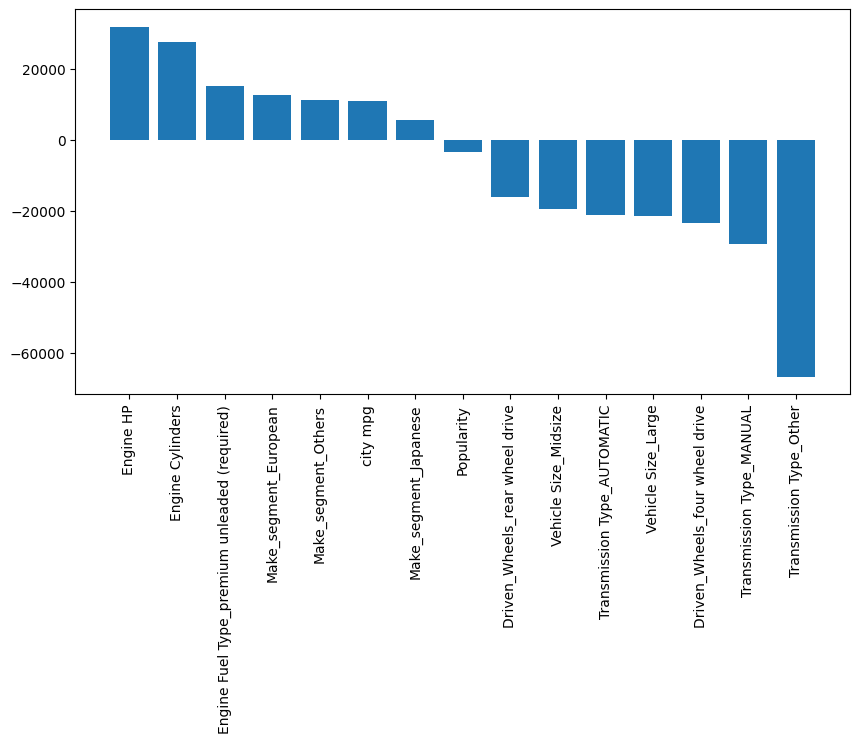

In [151]:
# Visualización de la importancia de las variables
plt.figure(figsize=(10,5))
plt.bar(range(X_train_dum[selected_features].shape[1]), importances[indices])
plt.xticks(range(X_train_dum[selected_features].shape[1]), [X_train_dum[selected_features].columns[i] for i in indices], rotation=90)
plt.show()

## ElasticNet

La regresión ElasticNet es un método de regularización que combina las penalizaciones L1 y L2 de la regresión de Lasso y Ridge. La regresión ElasticNet es útil cuando hay multicolinealidad en los datos y se desea seleccionar características importantes. La regresión ElasticNet minimiza la suma de los cuadrados de los errores de predicción y la suma de los valores absolutos de los coeficientes. La regresión ElasticNet es útil cuando hay muchas características en los datos y se desea evitar el sobreajuste. La regresión ElasticNet es útil cuando hay multicolinealidad en los datos y se desea seleccionar características importantes. La regresión ElasticNet es útil cuando hay multicolinealidad en los datos y se desea seleccionar características importantes.

In [152]:
from sklearn.linear_model import ElasticNet

In [153]:
# ElasticNet
elastic = ElasticNet(random_state=42)

In [154]:
# Entrenamiento
elastic.fit(X_train_dum[selected_features], y_train)

ElasticNet(random_state=42)

In [155]:
# Predicciones en train
y_pred = elastic.predict(X_train_dum[selected_features])
_, _ = calculate_metrics(y_train, y_pred)

MAE: 21742.377330887797, R2: 0.4280065054122184


In [156]:
# Predicciones en test
y_pred = elastic.predict(X_test_dum[selected_features])
mae, r2 = calculate_metrics(y_test, y_pred)

MAE: 21035.441276781632, R2: 0.5228664698772912


In [157]:
elastic_model = pd.DataFrame({'Modelo': ['ElasticNet'], 'MAE': [mae], 'R2': [r2]})

In [158]:
metricas_modelos = pd.concat([metricas_modelos, elastic_model], axis=0)
metricas_modelos

,Modelo,MAE,R2
0,Regresión Lineal (BaseLine),22739.625053,0.593114
0,Árbol de Decisión,5240.553082,0.901404
0,Árbol de Decisión (GridSearch),6501.310403,0.906815
0,Random Forest,4695.480550,0.952282
0,Random Forest (GridSearch),4753.081438,0.959629
0,XGBoost,4757.664698,0.924470
0,LightGBM,5913.447682,0.918062
0,K-Nearest Neighbors,6330.300165,0.903985
0,K-Nearest Neighbors (GridSearch),5247.478856,0.913767
0,Ridge,22744.929343,0.592969


In [164]:
# GridSearch
param_grid = {
    'alpha': [0.1, 0.5, 1, 5, 10, 50, 100, 200, 500],
    'l1_ratio': [0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 0.95]
}

In [165]:
# Definimos el modelo
elastic = ElasticNet(random_state=42)

In [166]:
# Búsqueda de hiperparámetros
grid_search = GridSearchCV(estimator=elastic, param_grid=param_grid, cv=2, n_jobs=-1, verbose=2)

In [167]:
# Entrenamiento
grid_search.fit(X_train_dum[selected_features], y_train)

Fitting 2 folds for each of 63 candidates, totalling 126 fits


GridSearchCV(cv=2, estimator=ElasticNet(random_state=42), n_jobs=-1,
             param_grid={'alpha': [0.1, 0.5, 1, 5, 10, 50, 100, 200, 500],
                         'l1_ratio': [0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 0.95]},
             verbose=2)

In [168]:
# Mejores hiperparámetros
grid_search.best_params_

{'alpha': 0.1, 'l1_ratio': 0.95}

In [169]:
# Mejor modelo
elastic = grid_search.best_estimator_

In [170]:
# Predicciones en train
y_pred = elastic.predict(X_train_dum[selected_features])
_, _ = calculate_metrics(y_train, y_pred)

MAE: 23143.981279722415, R2: 0.5016176525024808


In [171]:
# Predicciones en test
y_pred = elastic.predict(X_test_dum[selected_features])
mae, r2 = calculate_metrics(y_test, y_pred)

MAE: 22615.159165275247, R2: 0.5920587306396154


In [172]:
elastic_model = pd.DataFrame({'Modelo': ['ElasticNet (GridSearch)'], 'MAE': [mae], 'R2': [r2]})

In [173]:
metricas_modelos = pd.concat([metricas_modelos, elastic_model], axis=0)

In [174]:
metricas_modelos

,Modelo,MAE,R2
0,Regresión Lineal (BaseLine),22739.625053,0.593114
0,Árbol de Decisión,5240.553082,0.901404
0,Árbol de Decisión (GridSearch),6501.310403,0.906815
0,Random Forest,4695.480550,0.952282
0,Random Forest (GridSearch),4753.081438,0.959629
0,XGBoost,4757.664698,0.924470
0,LightGBM,5913.447682,0.918062
0,K-Nearest Neighbors,6330.300165,0.903985
0,K-Nearest Neighbors (GridSearch),5247.478856,0.913767
0,Ridge,22744.929343,0.592969


## Red neuronal

Las redes neuronales son un conjunto de algoritmos de aprendizaje automático que intentan imitar el comportamiento del cerebro humano. Actualmente, las redes neuronales son uno de los algoritmos de aprendizaje automático más utilizados en la industria, incluso existe un subcampo llamado aprendizaje profundo que se enfoca en la creación de redes neuronales con múltiples capas. La primera capa de la red neuronal es la capa de entrada, que recibe los datos de entrada. La última capa de la red neuronal es la capa de salida, que produce la salida de la red. Las capas intermedias de la red neuronal se llaman capas ocultas. Las redes neuronales son útiles para problemas de regresión y clasificación, y son especialmente útiles cuando hay muchas características en los datos y se desea evitar el sobreajuste. La primer red neuronal que vamos a probar es una red neuronal simple con una capa oculta.

In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

2024-04-30 19:49:25.931639: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-30 19:49:25.937564: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-30 19:49:25.984419: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-30 19:49:26.928288: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [30]:
# Red neuronal
model = Sequential()
model.add(Dense(64, input_dim=X_train_dum[selected_features].shape[1], activation='relu'))
model.add(Dense(1, activation='linear'))

/home/chidalgo/git/DS_Course/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:
# Compilación
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

El algoritmo Adam es un método de optimización que se utiliza para entrenar redes neuronales. Adam es una variante del descenso de gradiente estocástico que calcula tasas de aprendizaje adaptativas para cada parámetro. Adam es útil para problemas de regresión y clasificación, y es especialmente útil cuando hay muchas características en los datos y se desea evitar el sobreajuste.

In [32]:
# Entrenamiento
model.fit(X_train_dum[selected_features], y_train, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 624us/step - loss: 7748423680.0000
Epoch 2/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step - loss: 5945864192.0000
Epoch 3/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - loss: 6156256256.0000
Epoch 4/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - loss: 5412136960.0000
Epoch 5/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - loss: 6836660736.0000
Epoch 6/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - loss: 3872464128.0000
Epoch 7/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - loss: 5149406720.0000
Epoch 8/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - loss: 4646631424.0000
Epoch 9/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - loss: 2383746560.0000
Epoch 10/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - loss: 2851864832.0000
Epoch 11/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step - loss: 2693186560.0000
Epoch 12/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 2813366016.0000
Epoch 13/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 536u

In [33]:
# Predicciones en train
y_pred = model.predict(X_train_dum[selected_features])
_, _ = calculate_metrics(y_train, y_pred)

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
MAE: 14778.20907723301, R2: 0.6517413990466521


In [34]:
# Predicciones en test
y_pred = model.predict(X_test_dum[selected_features])
mae, r2 = calculate_metrics(y_test, y_pred)

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step
MAE: 15027.915510034522, R2: 0.7469657438172432


In [35]:
nn_model = pd.DataFrame({'Modelo': ['Red Neuronal'], 'MAE': [mae], 'R2': [r2]})

In [36]:
metricas_modelos = pd.concat([metricas_modelos, nn_model], axis=0)

In [37]:
metricas_modelos

,Modelo,MAE,R2
0,Regresión Lineal (BaseLine),22739.625053,0.593114
0,Red Neuronal,15027.915510,0.746966


## Red neuronal con regularización

In [38]:
# Red neuronal
model = Sequential()
model.add(Dense(64, input_dim=X_train_dum[selected_features].shape[1], activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dense(1, activation='linear'))

/home/chidalgo/git/DS_Course/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [39]:
# Compilación
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

In [40]:
# Entrenamiento
model.fit(X_train_dum[selected_features], y_train, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 567us/step - loss: 6998305280.0000
Epoch 2/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - loss: 6932817408.0000
Epoch 3/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step - loss: 6227095552.0000
Epoch 4/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - loss: 5778620416.0000
Epoch 5/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - loss: 5437577216.0000
Epoch 6/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - loss: 8200359424.0000
Epoch 7/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - loss: 4109212672.0000
Epoch 8/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - loss: 2903639040.0000
Epoch 9/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 3278426368.0000
Epoch 10/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - loss: 7269706752.0000
Epoch 11/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - loss: 3056144128.0000
Epoch 12/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - loss: 3391467264.0000
Epoch 13/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/

In [41]:
# Predicciones en train
y_pred = model.predict(X_train_dum[selected_features])
_, _ = calculate_metrics(y_train, y_pred)

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step
MAE: 14629.083484011853, R2: 0.6505860766504938


In [41]:
# Predicciones en test
y_pred = model.predict(X_test_dum[selected_features])
mae, r2 = calculate_metrics(y_test, y_pred)

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAE: 14842.661393658544, R2: 0.7460024892063626


In [42]:
nn_model = pd.DataFrame({'Modelo': ['Red Neuronal (Regularización)'], 'MAE': [mae], 'R2': [r2]})

In [43]:
metricas_modelos = pd.concat([metricas_modelos, nn_model], axis=0)

In [44]:
metricas_modelos

,Modelo,MAE,R2
0,Regresión Lineal (BaseLine),22739.625053,0.593114
0,Red Neuronal,15027.915510,0.746966
0,Red Neuronal (Regularización),14842.661394,0.746002


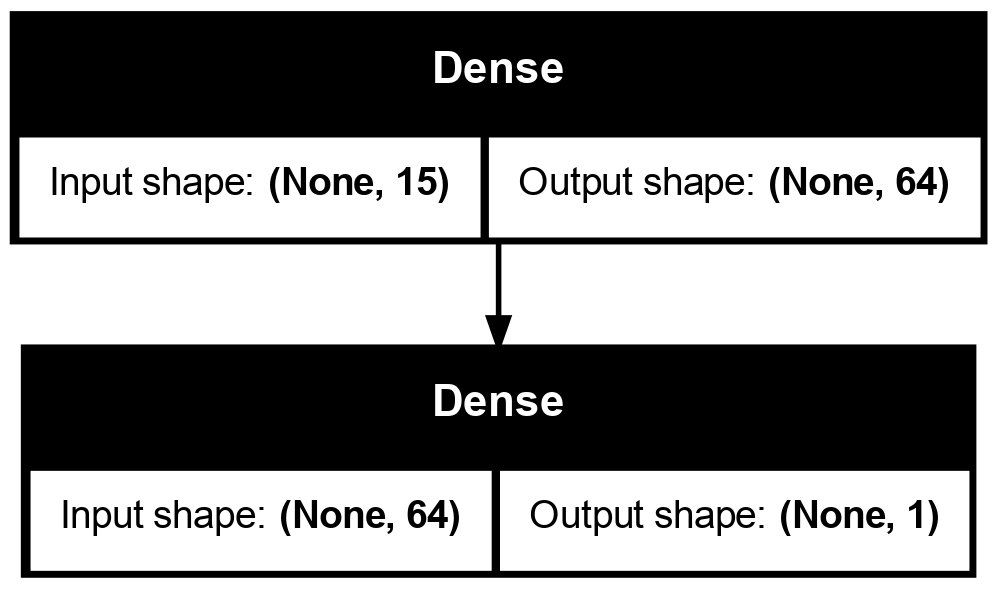

In [45]:
# Dibujar el modelo
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

## Red neuronal más compleja

In [46]:
# Red neuronal con capas intermedias
model = Sequential()
model.add(Dense(64, input_dim=X_train_dum[selected_features].shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='linear'))


/home/chidalgo/git/DS_Course/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [47]:
# Compilación
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

In [48]:
# Entrenamiento
model.fit(X_train_dum[selected_features], y_train, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 806us/step - loss: 7021608448.0000
Epoch 2/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - loss: 3502264832.0000
Epoch 3/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - loss: 1617908096.0000
Epoch 4/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - loss: 2708602624.0000
Epoch 5/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - loss: 1618049152.0000
Epoch 6/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - loss: 2810260992.0000
Epoch 7/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - loss: 1759156608.0000
Epoch 8/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - loss: 1660958592.0000
Epoch 9/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - loss: 1306048384.0000
Epoch 10/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - loss: 1695941632.0000
Epoch 11/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - loss: 1437585152.0000
Epoch 12/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step - loss: 1305909120.0000
Epoch 13/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 730u

In [49]:
# Predicciones en train
y_pred = model.predict(X_train_dum[selected_features])
_, _ = calculate_metrics(y_train, y_pred)

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
MAE: 9177.72312621517, R2: 0.8711351273778282


In [50]:
# Predicciones en test
y_pred = model.predict(X_test_dum[selected_features])

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step


In [51]:
mae, r2 = calculate_metrics(y_test, y_pred)

MAE: 9850.101783867733, R2: 0.8653101017818713


In [52]:
nn_model = pd.DataFrame({'Modelo': ['Red Neuronal (Compleja)'], 'MAE': [mae], 'R2': [r2]})

In [53]:
metricas_modelos = pd.concat([metricas_modelos, nn_model], axis=0)

In [54]:
metricas_modelos

,Modelo,MAE,R2
0,Regresión Lineal (BaseLine),22739.625053,0.593114
0,Red Neuronal,15027.915510,0.746966
0,Red Neuronal (Regularización),14842.661394,0.746002
0,Red Neuronal (Compleja),9850.101784,0.865310


## Red neuronal màs compleja todavía

In [99]:
# Red neuronal con capas intermedias
model = Sequential()
model.add(Dense(64, input_dim=X_train_dum[selected_features].shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(2, activation='relu'))
model.add(Dense(1, activation='linear'))

/home/chidalgo/git/DS_Course/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [100]:
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

In [101]:
model.fit(X_train_dum[selected_features], y_train, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 971us/step - loss: 4613228544.0000
Epoch 2/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3010983424.0000
Epoch 3/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2059521536.0000
Epoch 4/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - loss: 1276168448.0000
Epoch 5/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1843357184.0000
Epoch 6/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - loss: 1231226496.0000
Epoch 7/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 1239260416.0000
Epoch 8/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 1438722048.0000
Epoch 9/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1359318016.0000
Epoch 10/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1124295168.0000
Epoch 11/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1332528384.0000
Epoch 12/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - loss: 1012555712.0000
Epoch 13/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - los

In [102]:
y_pred = model.predict(X_train_dum[selected_features])
_, _ = calculate_metrics(y_train, y_pred)

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAE: 8968.580704657676, R2: 0.8684741473622342


In [103]:
y_pred = model.predict(X_test_dum[selected_features])

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step


In [104]:
mae, r2 = calculate_metrics(y_test, y_pred)

MAE: 9385.998656522117, R2: 0.9134413877372347


In [105]:
nn_model = pd.DataFrame({'Modelo': ['Red Neuronal (Compleja)'], 'MAE': [mae], 'R2': [r2]})

In [106]:
metricas_modelos = pd.concat([metricas_modelos, nn_model], axis=0)

In [107]:
metricas_modelos

,Modelo,MAE,R2
0,Regresión Lineal (BaseLine),22739.625053,0.593114
0,Red Neuronal,15027.915510,0.746966
0,Red Neuronal (Regularización),14842.661394,0.746002
0,Red Neuronal (Compleja),9850.101784,0.865310
0,Red Neuronal (Compleja),9692.922705,0.887477
0,Red Neuronal (Compleja),9117.526382,0.905947
0,Red Neuronal (Compleja),9385.998657,0.913441
